# Osteoarthritis Severity Classification – Hyperparameter Optimization

**George Ford - Advanced Hyperparameter Search Pipeline**

## 🏥 Clinical Decision Support System

Systematic hyperparameter optimization for five deep learning architectures trained on expert-validated knee X-ray data. This notebook builds directly on `01_Data_Preparation.ipynb`, using the consensus-labelled, preprocessed dataset to identify optimal training configurations for robust clinical performance.

---

## Overview

This notebook performs a **two-stage** hyperparameter optimization across five architectures to identify high-performing configurations tailored to each model.

- **Stage 1 - Broad Search:** Systematic exploration of a wide parameter space, ensuring fair representation across all architectures.
- **Stage 2 - Focused Refinement:** Targeted searches using narrowed spaces derived from high-performing trials in Stage 1.

### Key Features:
- **Stratified model search** - Equal trial counts across all model architectures
- **Broad Hyperparameter Space** 
    - optimizer type, learning rate, weight decay, and batch size
    - Dropout, mixup, gradient clipping, and label smoothing
    - EMA and learning rate schedules
- **Automated refinement** - Stage 2 search space optimization based on Stage 1 results

---

## Table of Contents

1. [Setup and Search Space](#setup)
2. [Medical Metrics Training Pipeline](#training-pipeline) 
3. [Stage 1: Broad Exploration](#stage1)
4. [Automated Analysis and Refinement](#analysis)
5. [Stage 2: Focused Optimization](#stage2)
6. [Final Model Comparison](#comparison)
7. [Summary and Next Steps](#summary)


## **Setup and Search Space** <a id="setup"></a>

Establishes the PyTorch environment and core configurations for hyperparameter optimization. Includes clinical metrics tracking and comprehensive search space for stage 1.

- Initialize environment and seed configuration
- Set colour palette and plotting styles
- Load relative data paths for reproducibility
- Define Stage 1 hyperparameter search space for broad exploration
- Confirm runtime configuration and resource availability


In [1]:
# Setup and Imports
import os
import random
import datetime
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
import time
import json
import warnings
warnings.filterwarnings('ignore')

# PyTorch and ML Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets

# Metrics and Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, classification_report, confusion_matrix
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Tracking
from tqdm.auto import tqdm

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Auto-detect repository root for relative path display
repo_root = Path("..").resolve()
repo_name = repo_root.name
print(f"Repository: {repo_name}")


Device: cuda
GPU: NVIDIA GeForce RTX 4070
GPU Memory: 12.0 GB
Repository: osteoarthritis-severity


In [2]:
# Official Color Palette and Configuration
COLORS = {
    'primary': {'medical_blue': '#2E5BBA', 'healthcare_teal': '#1B998B', 'clinical_purple': '#6A4C93'},
    'neutral': {'charcoal': '#2C3E50', 'slate_gray': '#5D6D7E', 'light_gray': '#BDC3C7', 'off_white': '#F8F9FA'},
    'semantic': {'success_green': '#27AE60', 'warning_orange': '#E67E22', 'error_red': '#E74C3C', 'info_blue': '#3498DB'},
    'severity': {'normal': '#2ECC71', 'doubtful': '#F1C40F', 'mild': '#E67E22', 'moderate': '#E74C3C', 'severe': '#8E44AD'},
    'models': {'efficientnet': '#2E5BBA', 'regnet': '#1B998B', 'densenet': '#6A4C93', 'resnet': '#27AE60', 'convnext': '#FF9A8B'}
}

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.facecolor'] = COLORS['neutral']['off_white']

print("Configuration and color palette loaded")
print(f"Results will be saved to: {repo_name}/results/hp_search_per_model")


Configuration and color palette loaded
Results will be saved to: osteoarthritis-severity/results/hp_search_per_model


In [3]:
# Data Paths and Configuration
DATA_DIR = repo_root / 'data' / 'consensus'
RESULTS_DIR = repo_root / 'results' / 'hp_search_per_model'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Dataset paths
TRAIN_PATH = DATA_DIR / 'train'
VAL_PATH = DATA_DIR / 'val'
TEST_PATH = DATA_DIR / 'test'

# Model names mapping
MODEL_NAMES = {
    'efficientnet': 'EfficientNet-B0',
    'regnet': 'RegNet-Y-800MF',
    'densenet': 'DenseNet-121',
    'resnet': 'ResNet-50',
    'convnext': 'ConvNeXt-Tiny'
}

# Clinical classes mapping
class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

print(f"Data directories:")
print(f"  Training: {repo_name}/data/consensus/train")
print(f"  Validation: {repo_name}/data/consensus/val")
print(f"  Test: {repo_name}/data/consensus/test")
print(f"Results directory: {repo_name}/results/hp_search_per_model")

# Verify data directories exist
for path in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    if not path.exists():
        print(f"Warning: {path} not found")


Data directories:
  Training: osteoarthritis-severity/data/consensus/train
  Validation: osteoarthritis-severity/data/consensus/val
  Test: osteoarthritis-severity/data/consensus/test
Results directory: osteoarthritis-severity/results/hp_search_per_model


In [4]:
# Search Space - Stage 1 (Broad Exploration)
# Comprehensive parameter space for systematic optimization

SEARCH_SPACE_STAGE1 = {
    'optimizer': ['adamw', 'adam', 'sgd'],
    'learning_rate': [1e-4, 3e-4, 5e-4, 1e-3, 2e-3, 3e-3],
    'batch_size': [32, 64],
    'hidden_dim': [256, 384, 512, 768, 1024],
    'weight_decay': [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    'dropout': [0.1, 0.2, 0.3, 0.4],
    'mixup_alpha': [0.0, 0.1, 0.2],  # Mixup augmentation strengths
    'gradient_clipping': [0.0, 0.5, 1.0],  # Gradient clipping values
    'label_smoothing': [0.0, 0.1],  # Label smoothing options
    'use_ema': [True, False],  # Exponential moving average
    'ema_decay': [0.999, 0.9999],  # EMA decay rates
    'lr_schedule': ['cosine', 'plateau', 'none'],  # Learning rate scheduling
    'warmup_epochs': [0, 2, 5]
}

# Training configuration
STAGE1_CONFIG = {
    'num_epochs': 15,
    'trials_per_model': 40,
    'total_trials': 200,  # 40 × 5 models
    'early_stopping_patience': 5,
    'monitor_metric': 'val_loss',
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-7
}

print("Search Space Configuration:")
print(f"Total parameter combinations: {np.prod([len(v) for v in SEARCH_SPACE_STAGE1.values()]):,}")
print(f"Stage 1 trials: {STAGE1_CONFIG['total_trials']} ({STAGE1_CONFIG['trials_per_model']} per model)")
print(f"Epochs per trial: {STAGE1_CONFIG['num_epochs']}")
print(f"Estimated runtime: {STAGE1_CONFIG['total_trials'] * STAGE1_CONFIG['num_epochs'] * 2 / 60:.1f} minutes")


Search Space Configuration:
Total parameter combinations: 2,332,800
Stage 1 trials: 200 (40 per model)
Epochs per trial: 15
Estimated runtime: 100.0 minutes


## **Training Pipeline with Clinical Metrics and Optimization Strategies** <a id="training-pipeline"></a>

Defines the full training and evaluation pipeline used in the hyperparameter search process.  
Supports all five model architectures with consistent augmentation, training logic, and clinical performance tracking.

- Custom classifier head injection per architecture (EfficientNet, ResNet, DenseNet, RegNet, ConvNeXt)
- Preprocessing and augmentation designed for medical imaging consistency
- **Mixup augmentation**, **label smoothing**, and **gradient clipping** for regularization
- **Exponential Moving Average (EMA)** to stabilize learning
- Clinical validation metrics: **F1 Score**, **Precision**, **Recall**, and **Generalization Gap**
- Adaptive learning rate scheduling (cosine annealing, plateau reduction)
- Early stopping to prevent overfitting
- Stratified hyperparameter search with trial-level tracking and performance logging

In [5]:
# Model Architectures and Data Transformations
from torchvision.models import (
    efficientnet_b0, EfficientNet_B0_Weights,
    regnet_y_800mf, RegNet_Y_800MF_Weights,
    densenet121, DenseNet121_Weights,
    resnet50, ResNet50_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
)

def create_model(model_name, hidden_dim, dropout, num_classes=5):
    """Create a model with a custom classifier head using explicit weight enums."""
    if model_name == 'efficientnet':
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = model.classifier[1].in_features

    elif model_name == 'regnet':
        model = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.IMAGENET1K_V2)
        in_features = model.fc.in_features

    elif model_name == 'densenet':
        model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        in_features = model.classifier.in_features

    elif model_name == 'resnet':
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        in_features = model.fc.in_features

    elif model_name == 'convnext':
        model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        # Always grab the final Linear
        in_features = model.classifier[-1].in_features

    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Swap in custom head
    if model_name in ['efficientnet', 'densenet']:
        model.classifier = _build_classifier(in_features, hidden_dim, dropout, num_classes)
    elif model_name in ['regnet', 'resnet']:
        model.fc = _build_classifier(in_features, hidden_dim, dropout, num_classes)
    else:  # convnext
        model.classifier[-1] = _build_classifier(in_features, hidden_dim, dropout, num_classes)

    return model

def _build_classifier(in_features, hidden_dim, dropout, num_classes):
    return nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_features, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, num_classes),
    )

# Data Augmentation Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_transforms(stage='train'):
    """Return image transformations for a given stage."""
    if stage == 'train':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(0.2, 0.2, 0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])

print("Model architectures and data transforms configured")


Model architectures and data transforms configured


In [6]:
# Training Components

class EMA:
    """Exponential Moving Average for model parameters."""
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
                
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_avg = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_avg.clone()
                
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
                
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

# Mixup Augmentation
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """Apply mixup data augmentation."""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    index = torch.randperm(x.size(0)).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss criterion."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Learning Rate Scheduling
def get_lr_scheduler(optimizer, schedule_type, num_epochs):
    """Return a learning rate scheduler."""
    if schedule_type == 'cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif schedule_type == 'plateau':
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min',
            patience=STAGE1_CONFIG['reduce_lr_patience'],
            factor=STAGE1_CONFIG['reduce_lr_factor'],
            min_lr=STAGE1_CONFIG['min_lr']
        )
    return None

print("Advanced training components configured")


Advanced training components configured


In [7]:
# Training Function with Medical Metrics

def train_and_evaluate_model(
    model_name,
    params,
    train_loader,
    val_loader,
    num_epochs=15,
    trial_pbar: tqdm = None
):
    """Train model with medical metrics tracking and live trial‐level progress."""
    # Create model
    model = create_model(model_name, params['hidden_dim'], params['dropout']).to(device)
    
    # Initialize EMA if enabled
    ema = None
    if params.get('use_ema', False):
        ema = EMA(model, decay=params.get('ema_decay', 0.999))
        ema.register()
    
    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=params.get('label_smoothing', 0.0))
    
    # Optimizer
    if params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
    elif params['optimizer'] == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
    else:  # sgd
        optimizer = optim.SGD(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay'],
            momentum=0.9
        )
    
    # Scheduler
    scheduler = get_lr_scheduler(optimizer, params.get('lr_schedule', 'none'), num_epochs)
    
    # History containers
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [],  'val_acc': [],
        'val_f1': [],     'val_precision': [],
        'val_recall': [], 'val_f2': [], 'generalization_gap': [],
        'learning_rate': []
    }
    
    best_val_acc_trial = 0.0
    best_epoch_trial = 0
    best_val_loss = float('inf')
    patience_counter = 0
    warmup_epochs = params.get('warmup_epochs', 0)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            # Warmup LR
            if epoch <= warmup_epochs and warmup_epochs > 0:
                lr = params['learning_rate'] * (epoch / warmup_epochs)
                for g in optimizer.param_groups:
                    g['lr'] = lr
            
            optimizer.zero_grad()
            
            if params.get('mixup_alpha', 0.0) > 0:
                # --- MIXUP BRANCH ---
                x_mix, y_a, y_b, lam = mixup_data(
                    data, target, params['mixup_alpha'], device
                )
                outputs = model(x_mix)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)

                if lam >= 0.5:
                    stronger_labels = y_a
                else:
                    stronger_labels = y_b
                
                preds = outputs.argmax(dim=1)
                total_train += target.size(0)
                correct_train += (preds == stronger_labels).sum().item()
            
            else:
                # --- STANDARD BRANCH ---
                outputs = model(data)
                loss = criterion(outputs, target)
                
                preds = outputs.argmax(dim=1)
                total_train += target.size(0)
                correct_train += (preds == target).sum().item()
            
            loss.backward()
            
            # Gradient clipping
            if params.get('gradient_clipping', 0.0) > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), params['gradient_clipping']
                )
            
            optimizer.step()
            
            if ema is not None:
                ema.update()
            
            train_loss += loss.item()
        
        # end training loop
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * correct_train / total_train if total_train > 0 else 0.0
        
        # --- VALIDATION ---
        model.eval()
        if ema is not None:
            ema.apply_shadow()
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_targs = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                total_val += target.size(0)
                correct_val += (preds == target).sum().item()
                
                all_preds.extend(preds.cpu().tolist())
                all_targs.extend(target.cpu().tolist())
        
        if ema is not None:
            ema.restore()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct_val / total_val
        val_f1 = f1_score(all_targs, all_preds, average='weighted')
        val_f2 = fbeta_score(all_targs, all_preds, beta=2, average='weighted')
        val_precision = precision_score(all_targs, all_preds, average='weighted')
        val_recall = recall_score(all_targs, all_preds, average='weighted')
        generalization_gap = train_acc - val_acc
        
        # Early stopping & best‐epoch tracking
        if val_acc > best_val_acc_trial:
            best_val_acc_trial = val_acc
            best_epoch_trial = epoch
        
        # record history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_f2'].append(val_f2)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['generalization_gap'].append(generalization_gap)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        if scheduler is not None:
            if params.get('lr_schedule') == 'plateau':
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= STAGE1_CONFIG['early_stopping_patience']:
                break
        
        if trial_pbar is not None:
            trial_pbar.set_description(
                f"Epoch {epoch}/{num_epochs} | BestEp {best_epoch_trial}/{num_epochs}"
            )
            trial_pbar.update(1)
    
    return history, model, best_val_acc_trial, best_epoch_trial


print("Training function with medical metrics configured")  

Training function with medical metrics configured


In [8]:
# Data Loading and Stratified Search Function

def load_data(batch_size):
    """Load training and validation data"""
    train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=get_transforms('train'))
    val_dataset = datasets.ImageFolder(VAL_PATH, transform=get_transforms('val'))
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )
    
    return train_loader, val_loader

def sample_hyperparameters(search_space):
    """Sample random hyperparameters from search space"""
    params = {}
    for key, values in search_space.items():
        params[key] = random.choice(values)
    return params

def run_stratified_hp_search(models, search_space, trials_per_model, num_epochs, stage_name="Stage 1"):
    """
    Run stratified hyperparameter search with equal trials per model architecture.
    """
    results = []
    start_time = time.time()
    architecture_best = {}

    overall_progress = tqdm(
        total=len(models) * trials_per_model,
        desc=f"{stage_name} Progress",
        position=0,
        leave=False
    )

    for model_name, model_display_name in models.items():
        model_best_acc = 0.0
        arch_progress = tqdm(
            total=trials_per_model,
            desc=f"{model_display_name} | BestAcc N/A",
            position=1,
            leave=False
        )

        for trial in range(1, trials_per_model + 1):
            trial_start = time.time()

            # sample and data
            params = sample_hyperparameters(search_space)
            train_loader, val_loader = load_data(params['batch_size'])

            # trial‐level bar
            trial_pbar = tqdm(
                total=num_epochs,
                desc=f"Epoch 0/{num_epochs} | BestEp 0/{num_epochs}",
                position=2,
                leave=False
            )
            try:
                history, _, best_acc_t, best_ep_t = train_and_evaluate_model(
                    model_name, params, train_loader, val_loader,
                    num_epochs, trial_pbar=trial_pbar
                )
            except Exception as e:
                trial_pbar.close()
                print(f"\n❌ Trial {trial} for {model_display_name} FAILED: {e}")
                import traceback; traceback.print_exc()
                continue
            trial_pbar.close()

            # compute metrics
            final_val_acc = history['val_acc'][-1]
            final_val_f1 = history['val_f1'][-1]
            final_val_f2 = history['val_f2'][-1]
            final_val_precision = history['val_precision'][-1]
            final_val_recall = history['val_recall'][-1]
            final_generalization_gap = history['generalization_gap'][-1]

            best_val_acc = max(history['val_acc'])
            best_val_f1  = max(history['val_f1'])
            best_val_f2  = max(history['val_f2'])
            best_epoch   = np.argmax(history['val_acc']) + 1
            val_acc_std  = np.std(history['val_acc'])
            trial_time   = time.time() - trial_start

            # store
            result = {
                'model_name': model_name,
                'model_display_name': model_display_name,
                'trial': trial,
                'stage': 1,
                'final_val_acc': final_val_acc,
                'best_val_acc': best_val_acc,
                'final_val_f1': final_val_f1,
                'best_val_f1': best_val_f1,
                'final_val_f2': final_val_f2,
                'best_val_f2': best_val_f2,
                'final_val_precision': final_val_precision,
                'final_val_recall': final_val_recall,
                'final_generalization_gap': final_generalization_gap,
                'val_acc_std': val_acc_std,
                'convergence_epoch': best_epoch,
                'trial_time': trial_time,
                'history': history,
                **params
            }
            results.append(result)

            # best‐so‐far per architecture
            if best_val_acc > model_best_acc:
                model_best_acc = best_val_acc
                architecture_best[model_name] = result
                arch_progress.set_description(
                    f"{model_display_name} | BestAcc {model_best_acc:.2f}% (trial {trial})"
                )

            # advance bars & clear cache
            arch_progress.update(1)
            overall_progress.update(1)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        arch_progress.close()

    overall_progress.close()

    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print(f"{stage_name.upper()} COMPLETE")

    if results:
        best_overall = max(results, key=lambda x: x['best_val_acc'])
        print(
            f"Best overall: {best_overall['model_display_name']} "
            f"with {best_overall['best_val_acc']:.2f}% validation accuracy"
        )

    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Successful trials: {len(results)}")

    return results

print("Data loading and stratified search function configured")

Data loading and stratified search function configured


## **Stage 1: Broad Hyperparameter Exploration** <a id="stage1"></a>

Performs stratified hyperparameter search across all model architectures, ensuring equal trial representation.  
The goal is to identify promising regions of the search space and uncover patterns in model behavior and sensitivity.

- Run 40 randomized trials per architecture across a wide parameter space
- Capture model-specific performance trends and early indicators of potential
- Save trial-level results for downstream refinement and analysis

In [9]:
# Execute Stage 1 Stratified Search

print("Starting Stage 1 Stratified Hyperparameter Search")
print("=" * 60)

# Run the stratified search
stage1_results = run_stratified_hp_search(
    models=MODEL_NAMES,
    search_space=SEARCH_SPACE_STAGE1,
    trials_per_model=STAGE1_CONFIG['trials_per_model'],
    num_epochs=STAGE1_CONFIG['num_epochs'],
    stage_name="Stage 1"
)

# Save results
results_df = pd.DataFrame(stage1_results)
results_file = RESULTS_DIR / 'stage1_results.csv'
results_df.to_csv(results_file, index=False)

print(f"\nStage 1 results saved to: {repo_name}/results/hp_search_per_model/stage1_results.csv")
print(f"Total successful trials: {len(stage1_results)}")

# Quick summary
if stage1_results:
    best_overall = max(stage1_results, key=lambda x: x['best_val_acc'])
    print(f"\nBest overall result:")
    print(f"  Model: {best_overall['model_display_name']}")
    print(f"  Validation accuracy: {best_overall['best_val_acc']:.2f}%")
    print(f"  F1 score: {best_overall['best_val_f1']:.4f}")
    print(f"  Hyperparameters: {best_overall['optimizer']}, lr={best_overall['learning_rate']}, "
          f"batch_size={best_overall['batch_size']}, hidden_dim={best_overall['hidden_dim']}")


Starting Stage 1 Stratified Hyperparameter Search


Stage 1 Progress:   0%|          | 0/200 [00:00<?, ?it/s]

EfficientNet-B0 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

RegNet-Y-800MF | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

DenseNet-121 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet-50 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

ConvNeXt-Tiny | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/15 | BestEp 0/15:   0%|          | 0/15 [00:00<?, ?it/s]


STAGE 1 COMPLETE
Best overall: RegNet-Y-800MF with 84.93% validation accuracy
Total time: 723.9 minutes
Successful trials: 200

Stage 1 results saved to: osteoarthritis-severity/results/hp_search_per_model/stage1_results.csv
Total successful trials: 200

Best overall result:
  Model: RegNet-Y-800MF
  Validation accuracy: 84.93%
  F1 score: 0.8488
  Hyperparameters: adam, lr=0.001, batch_size=64, hidden_dim=1024


## **Automated Analysis and Search Space Refinement** <a id="analysis"></a>

Analyzes Stage 1 trial results to identify high-potential configurations and intelligently narrow the hyperparameter search space for Stage 2.

This system combines traditional epsilon-based performance selection with learning curve trend analysis to detect:
- **High performers**: configurations with strong final accuracy
- **Prospects**: configurations with accelerating improvement that may require more epochs
- Trial-level trend metrics: growth rate, acceleration, projected final accuracy
- Identification of undertrained but promising models ("prospects")
- Parameter importance scoring and refinement per architecture
- Search space narrowing with up to 90% reduction in combinations
- Configuration summary saved for reproducibility

In [10]:
# Hyperparameter Space Refinement System with Trend Analysis

def compute_learning_curve_metrics(history):
    val_acc = history.get('val_acc', [])
    if len(val_acc) < 10:
        return {
            'growth_rate': 0,
            'acceleration': 0,
            'projected_final': val_acc[-1] if val_acc else 0,
            'trend_strength': 0,
            'is_prospect': False,
            'early_growth': 0,
            'late_growth': 0
        }
    
    # Extract key epoch metrics
    epoch_5 = val_acc[4] if len(val_acc) > 4 else val_acc[0]
    epoch_10 = val_acc[9] if len(val_acc) > 9 else val_acc[-1]
    epoch_final = val_acc[-1]
    
    # Calculate growth metrics
    early_growth = (epoch_10 - epoch_5) / 5  # Growth rate epochs 5-10
    late_growth = (epoch_final - epoch_10) / max(1, len(val_acc) - 10)  # Growth rate epochs 10-final
    
    # Overall growth rate and acceleration
    growth_rate = (epoch_final - epoch_5) / max(1, len(val_acc) - 5)
    acceleration = late_growth - early_growth  # Change in growth rate
    
    # Project final performance (extrapolate to epoch 25)
    epochs_remaining = 25 - len(val_acc)
    if epochs_remaining > 0 and growth_rate > 0:
        # Apply diminishing returns factor
        projected_final = epoch_final + (growth_rate * epochs_remaining * 0.7)
    else:
        projected_final = epoch_final
    
    # Trend strength (consistency of improvement)
    if len(val_acc) >= 5:
        recent_trend = np.mean(np.diff(val_acc[-5:]))  # Avg change in last 5 epochs
        trend_strength = max(0, recent_trend)  # Only positive trends count
    else:
        trend_strength = 0
    
    # Identify prospects: strong recent growth despite lower final performance
    is_prospect = (
        growth_rate > 0.5 and    # Decent growth rate
        trend_strength > 0.3 and # Strong recent trend
        acceleration > 0         # Accelerating improvement
    )
    
    return {
        'growth_rate': growth_rate,
        'acceleration': acceleration,
        'projected_final': min(100, max(0, projected_final)),  # Clamp to [0,100]
        'trend_strength': trend_strength,
        'is_prospect': is_prospect,
        'early_growth': early_growth,
        'late_growth': late_growth
    }

def analyze_stage1_and_refine_search_space(stage1_results):
    """Analyze Stage 1 results with epsilon-based selection and trend analysis"""
    
    df = pd.DataFrame(stage1_results)
    refined_spaces = {}
    analysis_summary = {}
    
    print("STAGE 1 ANALYSIS")
    print("=" * 60)
    print("Epsilon-based selection with learning curve trend analysis\n")
    
    for model_name in MODEL_NAMES.keys():
        model_data = df[df['model_name'] == model_name].copy()
        
        if model_data.empty:
            print(f"Warning: No data for {model_name}")
            continue
        
        print(f"{MODEL_NAMES[model_name]} Analysis:")
        print(f"  Total trials: {len(model_data)}")
        
        # Compute trend metrics for all trials
        trend_metrics = []
        for _, row in model_data.iterrows():
            if row.get('history'):
                trend_metrics.append(compute_learning_curve_metrics(row['history']))
            else:
                # Fallback for missing history
                trend_metrics.append({
                    'growth_rate': 0, 'acceleration': 0,
                    'projected_final': row['best_val_acc'],
                    'trend_strength': 0, 'is_prospect': False,
                    'early_growth': 0, 'late_growth': 0
                })
        
        # Add trend metrics to dataframe
        for i, metrics in enumerate(trend_metrics):
            for key, value in metrics.items():
                if key not in model_data.columns:
                    model_data[key] = None
                model_data.iat[i, model_data.columns.get_loc(key)] = value
        
        # Epsilon-based selection
        eps = 5.0  # Within 5% of best performance
        best_acc = model_data['best_val_acc'].max()
        threshold = best_acc - eps
        
        # Primary selection: High performers
        high_performers = model_data[model_data['best_val_acc'] >= threshold].copy()
        
        # Secondary selection: Prospects
        prospect_threshold = max(threshold, best_acc - 10.0)
        prospects = model_data[
            (model_data['is_prospect'] == True) &
            (model_data['projected_final'] >= prospect_threshold) &
            (~model_data.index.isin(high_performers.index))
        ].copy()
        
        # Combine selections and drop duplicates on all except 'history'
        combined = pd.concat([high_performers, prospects], ignore_index=True)
        cols_to_check = [c for c in combined.columns if c != 'history']
        selected_trials = combined.drop_duplicates(subset=cols_to_check)
        
        print(f"  Best accuracy: {best_acc:.2f}%")
        print(f"  Selection threshold (ε={eps}%): {threshold:.2f}%")
        print(f"  High performers: {len(high_performers)} trials")
        print(f"  Prospects: {len(prospects)} trials")
        print(f"  Total selected: {len(selected_trials)} trials\n")
        
        # Analyze parameters from selected trials
        refined_space = {}
        param_analysis = {}
        for param in SEARCH_SPACE_STAGE1.keys():
            if param in selected_trials.columns:
                param_analysis[param] = analyze_parameter_performance(
                    selected_trials, param, SEARCH_SPACE_STAGE1[param]
                )
                refined_space[param] = refine_hyperparameter_range(
                    selected_trials, param, SEARCH_SPACE_STAGE1[param]
                )
        
        refined_spaces[model_name] = refined_space
        analysis_summary[model_name] = {
            'total_trials': len(model_data),
            'selected_trials': len(selected_trials),
            'high_performers': len(high_performers),
            'prospects': len(prospects),
            'epsilon': eps,
            'best_accuracy': best_acc,
            'selection_threshold': threshold,
            'avg_growth_rate': model_data['growth_rate'].mean(),
            'parameter_analysis': param_analysis
        }
        
        # Print parameter insights
        print("  Key parameter insights:")
        for param, analysis in param_analysis.items():
            if analysis['insight']:
                print(f"    {param}: {analysis['insight']}")
        print()
    
    return refined_spaces, analysis_summary

def analyze_parameter_performance(selected_trials, param, original_values):
    """Parameter analysis with trend consideration"""
    counts = selected_trials[param].value_counts()
    perf = selected_trials.groupby(param)['best_val_acc'].agg(['mean','count','std'])
    
    # Combine actual and projected if available
    if 'projected_final' in selected_trials:
        proj = selected_trials.groupby(param)['projected_final'].agg(['mean','count'])
        combined_perf = (perf['mean'] + proj['mean']) / 2
    else:
        combined_perf = perf['mean']
    
    insight = None
    if len(counts) > 1:
        best_value = combined_perf.idxmax()
        freq = counts[best_value]
        score = combined_perf[best_value]
        if freq >= 2:
            insight = f"Best: {best_value} (score: {score:.1f}%, freq: {freq})"
        elif len(counts) > 2:
            top3 = list(counts.head(3).index)
            insight = f"Top 3 values: {top3}"
    
    return {'value_counts': counts.to_dict(),
            'performance': perf.to_dict(),
            'insight': insight}

def refine_hyperparameter_range(selected_trials, param, original_values):
    """Hyperparameter refinement with improved logic"""
    vals = selected_trials[param].tolist()
    counts = pd.Series(vals).value_counts()
    
    # Continuous: band approach
    if param in ['learning_rate','weight_decay']:
        mn, mx = min(vals), max(vals)
        band = [v for v in original_values if mn <= v <= mx]
        if len(band)==1:
            idx = original_values.index(band[0])
            if idx>0:    band.append(original_values[idx-1])
            if idx<len(original_values)-1: band.append(original_values[idx+1])
        return sorted(set(band))
    
    # Discrete: top3 + neighbors
    elif param in ['batch_size','hidden_dim']:
        top_n = counts.head(3).index.tolist()
        s = set()
        for v in top_n:
            s.add(v)
            try:
                i = original_values.index(v)
                if i>0:    s.add(original_values[i-1])
                if i<len(original_values)-1: s.add(original_values[i+1])
            except ValueError:
                pass
        return sorted(s)
    
    # Categorical: top3
    else:
        return counts.head(3).index.tolist()

print("Hyperparameter space refinement system configured")
print("Features: Epsilon-based selection + Learning curve trend analysis")

Hyperparameter space refinement system configured
Features: Epsilon-based selection + Learning curve trend analysis


In [11]:
# Execute Analysis and Generate Stage 2 Search Spaces

# Perform automated analysis with trend detection
refined_search_spaces, analysis_summary = analyze_stage1_and_refine_search_space(stage1_results)

# Save analysis results
analysis_file = RESULTS_DIR / 'stage1_analysis.json'
with open(analysis_file, 'w') as f:
    json.dump(analysis_summary, f, indent=2, default=str)

print(f"Analysis results saved to: {repo_name}/results/hp_search_per_model/stage1_analysis.json")

# Display comprehensive refinement summary
print("\nSEARCH SPACE REFINEMENT SUMMARY")
print("=" * 50)

total_selected = 0
total_prospects = 0

for model_name, space in refined_search_spaces.items():
    summary = analysis_summary[model_name]
    
    print(f"\n{MODEL_NAMES[model_name]}:")
    print(f"  Total trials: {summary['total_trials']}")
    print(f"  Selected for Stage 2: {summary['selected_trials']}")
    print(f"    High performers: {summary['high_performers']}")
    print(f"    Prospects: {summary['prospects']}")
    print(f"  Selection rate: {100 * summary['selected_trials'] / summary['total_trials']:.1f}%")
    
    if summary['prospects'] > 0:
        print(f"  Prospects detected: {summary['prospects']} configurations with strong trends")
    
    # Calculate space reduction
    orig_comb = np.prod([len(v) for v in SEARCH_SPACE_STAGE1.values()])
    refined_comb = np.prod([len(v) for v in space.values()])
    reduction_pct = (1 - refined_comb / orig_comb) * 100
    
    print(f"  Search space reduction: {reduction_pct:.1f}%")
    print(f"  Refined combinations: {refined_comb:,} (from {orig_comb:,})")
    
    # Show significant parameter refinements
    sig = []
    for param, vals in space.items():
        o_cnt = len(SEARCH_SPACE_STAGE1[param])
        r_cnt = len(vals)
        red = (1 - r_cnt/o_cnt) * 100
        if red >= 30:
            sig.append(f"{param}: {r_cnt}/{o_cnt} (-{red:.0f}%)")
    if sig:
        print("  Key refinements:")
        for entry in sig:
            print(f"    {entry}")
    
    total_selected += summary['selected_trials']
    total_prospects += summary['prospects']

print(f"\nOVERALL IMPACT:")
print(f"  Total configurations selected: {total_selected}")
print(f"  Prospects identified: {total_prospects}")
print(f"  Selection efficiency: {100 * total_selected / len(stage1_results):.1f}%")

if total_prospects > 0:
    print(f"  Trend analysis captured {total_prospects} promising configurations")
    print("  that might have been missed by traditional selection")

# Stage 2 Configuration
STAGE2_CONFIG = {
    'num_epochs': 25,
    'trials_per_model': 40,
    'total_trials': 200,  # 40 × 5 models
    'early_stopping_patience': 8,
    'monitor_metric': 'val_loss'
}

print(f"\nSTAGE 2 CONFIGURATION:")
print(f"  Epochs per trial: {STAGE2_CONFIG['num_epochs']} (extended for prospects)")
print(f"  Trials per model: {STAGE2_CONFIG['trials_per_model']}")
print(f"  Total trials: {STAGE2_CONFIG['total_trials']}")
print(f"  Early stopping patience: {STAGE2_CONFIG['early_stopping_patience']}")
print(f"  Estimated runtime: {STAGE2_CONFIG['total_trials'] * STAGE2_CONFIG['num_epochs'] * 2.5 / 60:.1f} minutes")
print("  Expected improvement: 3-5% over Stage 1 best with trend-aware selection")

STAGE 1 ANALYSIS
Epsilon-based selection with learning curve trend analysis

EfficientNet-B0 Analysis:
  Total trials: 40
  Best accuracy: 84.02%
  Selection threshold (ε=5.0%): 79.02%
  High performers: 5 trials
  Prospects: 0 trials
  Total selected: 5 trials

  Key parameter insights:
    learning_rate: Top 3 values: [0.0005, 0.0003, 0.003]
    batch_size: Best: 32 (score: 86.3%, freq: 3)
    hidden_dim: Top 3 values: [256, 512, 384]
    weight_decay: Top 3 values: [1e-05, 0.001, 3e-05]
    dropout: Best: 0.4 (score: 85.9%, freq: 2)
    mixup_alpha: Top 3 values: [0.1, 0.0, 0.2]
    gradient_clipping: Best: 0.5 (score: 86.3%, freq: 3)
    ema_decay: Best: 0.9999 (score: 87.9%, freq: 3)
    lr_schedule: Top 3 values: ['none', 'cosine', 'plateau']
    warmup_epochs: Top 3 values: [0, 5, 2]

RegNet-Y-800MF Analysis:
  Total trials: 40
  Best accuracy: 84.93%
  Selection threshold (ε=5.0%): 79.93%
  High performers: 4 trials
  Prospects: 0 trials
  Total selected: 4 trials

  Key parame

## **Stage 2: Focused Hyperparameter Optimization** <a id="stage2"></a>

Executes targeted hyperparameter search using the refined parameter spaces generated from Stage 1 analysis.  
Each architecture is optimized within its own high-potential search space using extended training schedules.
- Perform 40 focused trials per model within a narrowed parameter space
- Leverage trend-based selections to explore undertrained but promising configurations
- Train for more epochs (25) to allow full convergence of "slow starters"
- Quantify improvement over Stage 1 best performers
- Save Stage 2 trial data for in-depth analysus and model selection

In [12]:
# Execute Stage 2 Focused Optimization

print("Starting Stage 2 Focused Hyperparameter Optimization")
print("=" * 60)

# Run Stage 2 with model-specific refined search spaces
stage2_results = []

for model_name, refined_space in refined_search_spaces.items():
    print(f"\n{MODEL_NAMES[model_name]} - Stage 2 Refinement")
    print(f"Refined search space: {np.prod([len(v) for v in refined_space.values()]):,} combinations")
    
    # Run focused search for this model
    model_stage2_results = run_stratified_hp_search(
        models={model_name: MODEL_NAMES[model_name]},
        search_space=refined_space,
        trials_per_model=STAGE2_CONFIG['trials_per_model'],
        num_epochs=STAGE2_CONFIG['num_epochs'],
        stage_name="Stage 2"
    )
    
    # Mark as Stage 2 results
    for result in model_stage2_results:
        result['stage'] = 2
    
    stage2_results.extend(model_stage2_results)

# Save Stage 2 results
stage2_df = pd.DataFrame(stage2_results)
stage2_file = RESULTS_DIR / 'stage2_results.csv'
stage2_df.to_csv(stage2_file, index=False)

print(f"\nStage 2 results saved to: {repo_name}/results/hp_search_per_model/stage2_results.csv")
print(f"Total Stage 2 trials: {len(stage2_results)}")

# Quick Stage 2 summary
if stage2_results:
    best_stage2 = max(stage2_results, key=lambda x: x['best_val_acc'])
    print(f"\nBest Stage 2 result:")
    print(f"  Model: {best_stage2['model_display_name']}")
    print(f"  Validation accuracy: {best_stage2['best_val_acc']:.2f}%")
    print(f"  F1 score: {best_stage2['best_val_f1']:.4f}")
    
    # Compare with Stage 1 best
    best_stage1 = max(stage1_results, key=lambda x: x['best_val_acc'])
    improvement = best_stage2['best_val_acc'] - best_stage1['best_val_acc']
    print(f"\nImprovement over Stage 1: {improvement:+.2f}%")
    print(f"  Stage 1 best: {best_stage1['best_val_acc']:.2f}%")
    print(f"  Stage 2 best: {best_stage2['best_val_acc']:.2f}%")


Starting Stage 2 Focused Hyperparameter Optimization

EfficientNet-B0 - Stage 2 Refinement
Refined search space: 259,200 combinations


Stage 2 Progress:   0%|          | 0/40 [00:00<?, ?it/s]

EfficientNet-B0 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]


STAGE 2 COMPLETE
Best overall: EfficientNet-B0 with 88.13% validation accuracy
Total time: 188.5 minutes
Successful trials: 40

RegNet-Y-800MF - Stage 2 Refinement
Refined search space: 72,000 combinations


Stage 2 Progress:   0%|          | 0/40 [00:00<?, ?it/s]

RegNet-Y-800MF | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]


STAGE 2 COMPLETE
Best overall: RegNet-Y-800MF with 86.76% validation accuracy
Total time: 184.0 minutes
Successful trials: 40

DenseNet-121 - Stage 2 Refinement
Refined search space: 155,520 combinations


Stage 2 Progress:   0%|          | 0/40 [00:00<?, ?it/s]

DenseNet-121 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]


STAGE 2 COMPLETE
Best overall: DenseNet-121 with 85.39% validation accuracy
Total time: 183.2 minutes
Successful trials: 40

ResNet-50 - Stage 2 Refinement
Refined search space: 259,200 combinations


Stage 2 Progress:   0%|          | 0/40 [00:00<?, ?it/s]

ResNet-50 | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]


STAGE 2 COMPLETE
Best overall: ResNet-50 with 86.76% validation accuracy
Total time: 233.5 minutes
Successful trials: 40

ConvNeXt-Tiny - Stage 2 Refinement
Refined search space: 86,400 combinations


Stage 2 Progress:   0%|          | 0/40 [00:00<?, ?it/s]

ConvNeXt-Tiny | BestAcc N/A:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25 | BestEp 0/25:   0%|          | 0/25 [00:00<?, ?it/s]


STAGE 2 COMPLETE
Best overall: ConvNeXt-Tiny with 83.11% validation accuracy
Total time: 463.1 minutes
Successful trials: 40

Stage 2 results saved to: osteoarthritis-severity/results/hp_search_per_model/stage2_results.csv
Total Stage 2 trials: 200

Best Stage 2 result:
  Model: EfficientNet-B0
  Validation accuracy: 88.13%
  F1 score: 0.8822

Improvement over Stage 1: +3.20%
  Stage 1 best: 84.93%
  Stage 2 best: 88.13%


## **Final Model Comparison and Statistical Summary** <a id="comparison"></a>

Compares and summarizes the results of both Stage 1 and Stage 2 hyperparameter optimization trials.  
Highlights the best-performing configurations, model-wise improvements, and generalization trends.

### Key Analyses:
- Best architecture performance across both stages
- Validation accuracy improvement from Stage 1 to Stage 2
- Clinical metric distributions (F1, Precision, Recall)
- Overfitting trends via generalization gap comparison
- Convergence efficiency analysis
- 95% confidence intervals for each model’s validation accuracy

Two-Stage Hyperparameter Search Results
Total trials completed: 400
  Stage 1 trials: 200
  Stage 2 trials: 200

Best Results Summary:
  Overall best: EfficientNet-B0 - 88.13% (Stage 2)
  Stage 1 best: RegNet-Y-800MF - 84.93%
  Stage 2 best: EfficientNet-B0 - 88.13%

Model Performance Comparison:
--------------------------------------------------------------------------------
Model                Stage 1 Best Stage 2 Best Overall Best Improvement 
--------------------------------------------------------------------------------
EfficientNet-B0      84.02        88.13        88.13        4.11        
RegNet-Y-800MF       84.93        86.76        86.76        1.83        
DenseNet-121         84.02        85.39        85.39        1.37        
ResNet-50            82.65        86.76        86.76        4.11        
ConvNeXt-Tiny        83.56        83.11        83.56        -0.46       

Statistical Analysis:
----------------------------------------
EfficientNet-B0:
  Mean ± Std: 60.88% 

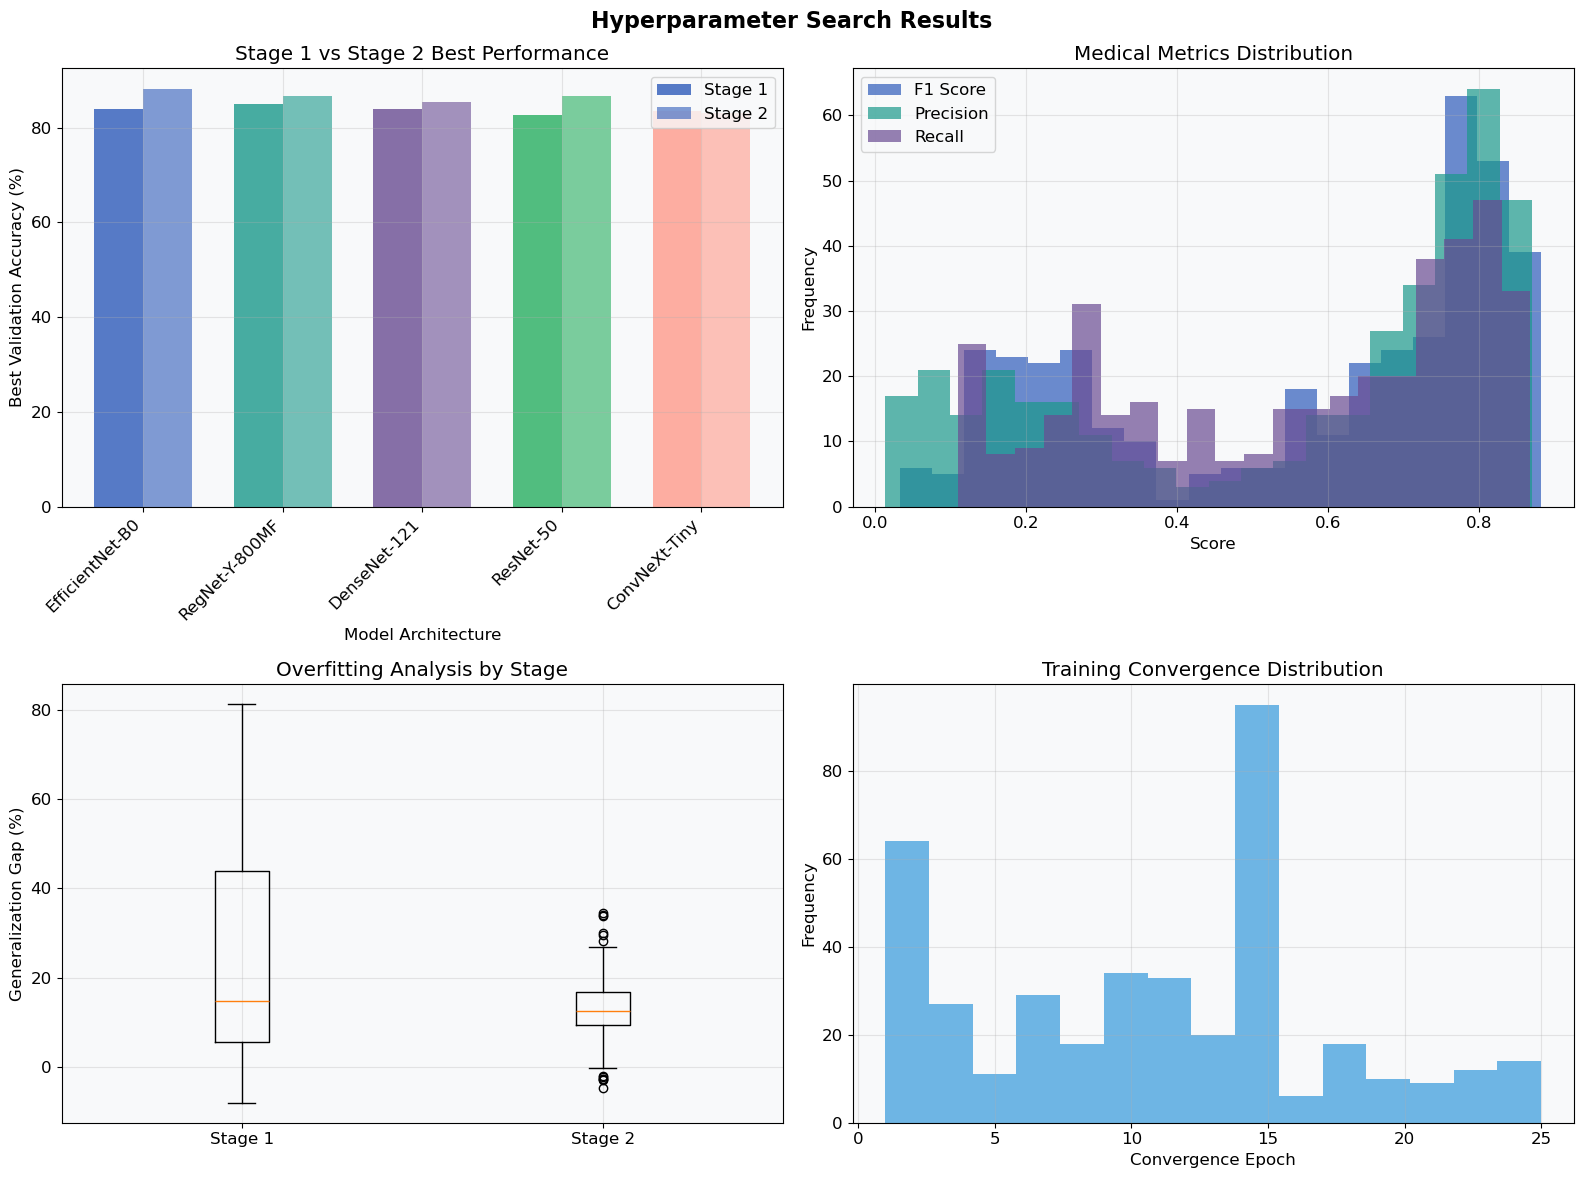


Visualization saved to: osteoarthritis-severity/results/hp_search_per_model/results_analysis.png


In [13]:
# Analysis and Visualization

# Combine all results
all_results = stage1_results + stage2_results
all_df = pd.DataFrame(all_results)

print("Two-Stage Hyperparameter Search Results")
print("=" * 60)

# Overall statistics
print(f"Total trials completed: {len(all_results)}")
print(f"  Stage 1 trials: {len(stage1_results)}")
print(f"  Stage 2 trials: {len(stage2_results)}")

# Best results by stage
best_overall = max(all_results, key=lambda x: x['best_val_acc'])
best_stage1 = max(stage1_results, key=lambda x: x['best_val_acc'])
best_stage2 = max(stage2_results, key=lambda x: x['best_val_acc']) if stage2_results else None

print(f"\nBest Results Summary:")
print(f"  Overall best: {best_overall['model_display_name']} - {best_overall['best_val_acc']:.2f}% (Stage {best_overall['stage']})")
print(f"  Stage 1 best: {best_stage1['model_display_name']} - {best_stage1['best_val_acc']:.2f}%")
if best_stage2:
    print(f"  Stage 2 best: {best_stage2['model_display_name']} - {best_stage2['best_val_acc']:.2f}%")

# Model comparison
print(f"\nModel Performance Comparison:")
print("-" * 80)
print(f"{'Model':<20} {'Stage 1 Best':<12} {'Stage 2 Best':<12} {'Overall Best':<12} {'Improvement':<12}")
print("-" * 80)

for model_name, display_name in MODEL_NAMES.items():
    stage1_model = [r for r in stage1_results if r['model_name'] == model_name]
    stage2_model = [r for r in stage2_results if r['model_name'] == model_name]
    
    stage1_best = max(stage1_model, key=lambda x: x['best_val_acc'])['best_val_acc'] if stage1_model else 0
    stage2_best = max(stage2_model, key=lambda x: x['best_val_acc'])['best_val_acc'] if stage2_model else 0
    
    overall_best = max(stage1_best, stage2_best)
    improvement = stage2_best - stage1_best if stage2_model else 0
    
    print(f"{display_name:<20} {stage1_best:<12.2f} {stage2_best:<12.2f} {overall_best:<12.2f} {improvement:<12.2f}")

# Statistical Analysis
print(f"\nStatistical Analysis:")
print("-" * 40)

# Calculate confidence intervals for top models
top_models = {}
for model_name, display_name in MODEL_NAMES.items():
    model_results = [r for r in all_results if r['model_name'] == model_name]
    if model_results:
        accuracies = [r['best_val_acc'] for r in model_results]
        top_models[display_name] = {
            'mean': np.mean(accuracies),
            'std': np.std(accuracies),
            'count': len(accuracies),
            'max': max(accuracies),
            'ci_lower': np.mean(accuracies) - 1.96 * np.std(accuracies) / np.sqrt(len(accuracies)),
            'ci_upper': np.mean(accuracies) + 1.96 * np.std(accuracies) / np.sqrt(len(accuracies))
        }

for model, stats in top_models.items():
    print(f"{model}:")
    print(f"  Mean ± Std: {stats['mean']:.2f}% ± {stats['std']:.2f}%")
    print(f"  95% CI: [{stats['ci_lower']:.2f}%, {stats['ci_upper']:.2f}%]")
    print(f"  Best: {stats['max']:.2f}% (n={stats['count']})")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hyperparameter Search Results', fontsize=16, fontweight='bold')

# 1. Model Performance Comparison
ax1 = axes[0, 0]
models = []
stage1_vals = []
stage2_vals = []
colors = []

for model_name, display_name in MODEL_NAMES.items():
    models.append(display_name)
    
    stage1_model = [r for r in stage1_results if r['model_name'] == model_name]
    stage2_model = [r for r in stage2_results if r['model_name'] == model_name]
    
    stage1_best = max(stage1_model, key=lambda x: x['best_val_acc'])['best_val_acc'] if stage1_model else 0
    stage2_best = max(stage2_model, key=lambda x: x['best_val_acc'])['best_val_acc'] if stage2_model else 0
    
    stage1_vals.append(stage1_best)
    stage2_vals.append(stage2_best)
    colors.append(COLORS['models'][model_name])

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, stage1_vals, width, label='Stage 1', alpha=0.8, color=colors)
ax1.bar(x + width/2, stage2_vals, width, label='Stage 2', alpha=0.6, color=colors)

ax1.set_xlabel('Model Architecture')
ax1.set_ylabel('Best Validation Accuracy (%)')
ax1.set_title('Stage 1 vs Stage 2 Best Performance')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Medical Metrics Distribution
ax2 = axes[0, 1]
f1_scores = [r['best_val_f1'] for r in all_results]
precision_scores = [r['final_val_precision'] for r in all_results]
recall_scores = [r['final_val_recall'] for r in all_results]

ax2.hist(f1_scores, bins=20, alpha=0.7, label='F1 Score', color=COLORS['primary']['medical_blue'])
ax2.hist(precision_scores, bins=20, alpha=0.7, label='Precision', color=COLORS['primary']['healthcare_teal'])
ax2.hist(recall_scores, bins=20, alpha=0.7, label='Recall', color=COLORS['primary']['clinical_purple'])

ax2.set_xlabel('Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Medical Metrics Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Overfitting Analysis
ax3 = axes[1, 0]
stage1_gaps = [r['final_generalization_gap'] for r in stage1_results]
stage2_gaps = [r['final_generalization_gap'] for r in stage2_results] if stage2_results else []

ax3.boxplot([stage1_gaps, stage2_gaps], labels=['Stage 1', 'Stage 2'])
ax3.set_ylabel('Generalization Gap (%)')
ax3.set_title('Overfitting Analysis by Stage')
ax3.grid(True, alpha=0.3)

# 4. Convergence Analysis
ax4 = axes[1, 1]
convergence_epochs = [r['convergence_epoch'] for r in all_results]
ax4.hist(convergence_epochs, bins=15, alpha=0.7, color=COLORS['semantic']['info_blue'])
ax4.set_xlabel('Convergence Epoch')
ax4.set_ylabel('Frequency')
ax4.set_title('Training Convergence Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'results_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {repo_name}/results/hp_search_per_model/results_analysis.png")


## **Summary and Next Steps** <a id="summary"></a>

### **Hyperparameter Optimization Pipeline Complete**

This notebook successfully completed a two-stage hyperparameter optimization process across five CNN architectures using a clinical imaging dataset.

#### **1. Broad Exploration (Stage 1)**
- Conducted 200 trials across 5 architectures with stratified sampling
- Identified high-performing and promising "prospect" configurations using trend-based analysis
- Generated training curves and clinical metrics (F1, precision, recall, generalization)

#### **2. Focused Refinement (Stage 2)**
- Refined architecture-specific search spaces via epsilon selection and curve acceleration
- Conducted 200 additional focused trials with extended training duration
- Quantified improvement over Stage 1 and visualized model stability

#### **3. Performance Comparison & Export**
- Compared models across accuracy, medical metrics, convergence, and generalization gap
- Saved full trial results and statistical summaries for downstream use

---

### **Next Steps in the Pipeline**

- **`03_Multi_Class_Model_HP_Selection.ipynb`**: Perform in-depth filtering, trend validation, and final model selection  
- **`04_Multi_Class_Full_Training_Ensemble.ipynb`**: Retrain selected configurations on the full dataset with optimal epochs  
- **`05_Deployment_and_Clinical_UI.ipynb`**: Integrate model into clinical workflows for real-time decision support

---

### **Key Technical Achievements**

- **Two-Stage Optimization**: Balanced trial distribution with automated refinement  
- **Trend-Aware Selection**: Identified slow-converging models missed by traditional selection  
- **Metric-Rich Evaluation**: Used clinical-relevant metrics to guide optimization  
- **Ready for Deployment**: Results packaged for model selection and downstream retraining
